### Анализ пользовательского поведения в мобильном приложении

Цель:
* По данным использования мобильного приложения для продажи продуктов питания нужно проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования.

---

**Описание данных**
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

---

**Описание проекта**

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений](#null)
    * [Обработка дубликатов](#duplicates)
    * [Изменение типов данных](#types)
    * [Добавление новых столбцов](#newсolumn)
3. [Изучение и проверка данных](#check)
    * [Количество событий в логе](#numberofevents)
    * [Количество пользователей](#numberofusers)
    * [Количество в среднем событий на пользователя](#avgeventsperuser)
    * [Актуальные данные](#actuality)
    * [Потерянные данные](#lost)
3. [Изучение воронки событий](#funnel)
    * [Квалификация событий](#eventsisin)
    * [Количество пользователей, которые совершали каждое из этих событий](#usersperevents)
    * [Порядок событий](#eventsteps)
    * [Воронка событий](#funnelpercent)
4. [Анализ результатов эксперемента](#AABtests)
    * [Количество пользователей в экспериментальных группах](#numberofuserstest)
    * [Статистическая значимость в долях конверсии 246 и 247](#statsdifference)
    * [Статистическая значимость контрольных групп и экспериентальной](#statABdiff)
5. [Вывод](#conclusion)

<a id='start'></a>
### Шаг 1.Изучение файлов с данными и общей информацией по ним

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats as st


import warnings
import math as mth
import ipywidgets as widgets

import plotly.io as pio
pio.renderers

from IPython.display import Image


In [2]:
path = ('/Users/valeriyaniskorodova/Y.Praktikum/Module 2/final sprint/')
#path = ('/datasets/')

In [3]:
logs_data = pd.read_csv(path +'logs_exp.csv', sep='\t')

In [4]:
logs_data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
logs_data = logs_data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id',\
                  'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'})

In [6]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


На первый взгляд пропущенных значений не обнаружено
* Следует заменить столбцы с информацией об id на тип str
* Привести столбец с данными о времени события к типа datetime.

<a id='preprocessing'></a>
### Шаг 2.Предобработка данных

<a id='null'></a>
Пропущенных значений не обнаружено.

<a id='types'></a>
**Изменение типов данных**

In [7]:
type_dict = {
    'user_id':'str',
    'exp_id':'str'
}
logs_data = logs_data.astype(type_dict)

In [8]:
logs_data['date_time'] = pd.to_datetime(logs_data['event_timestamp'], unit='s')

In [9]:
logs_data

,event_name,user_id,event_timestamp,exp_id,date_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


---

In [10]:
logs_data.duplicated().sum()

413

<a id='duplicates'></a>
В наших данных всего 413 дубликатов, это меньше 1% от всех данных, предполагаю, что такие дубликаты возникли из-за ошибок, возникщих при сборе данных о действиях на странице( задублирование действия). Удаление таких дубликатов не окажет искажения на результаты исследования.

---

In [11]:
logs_data = logs_data.drop_duplicates()

In [12]:
logs_data

,event_name,user_id,event_timestamp,exp_id,date_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


In [13]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  object        
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  object        
 4   date_time        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.2+ MB


<a id='newсolumn'></a>
Добавление столбец даты и времени

In [14]:
warnings.filterwarnings('ignore')

In [15]:
logs_data['date'] = logs_data['date_time'].astype('datetime64[D]')
logs_data['time'] = logs_data['date_time'].dt.time

In [16]:
logs_data.head()

,event_name,user_id,event_timestamp,exp_id,date_time,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,11:48:42


>* Пропусков в данных нет
>* Найдены дубликаты, мною было принято решение об их удалении, так как они занимают меньше 1% от всех данных
>* Добавила столбцы с информацией о дате и времени по отдельности
>* Изменены типы данных на подходящие


<a id='check'></a>
### Шаг 3. Изучение и проверка данных

<a id='numberofevents'></a>
**Количество событий в логе**

In [17]:
number_of_events = len(logs_data)
number_of_events

243713

Посмотрю, количество контроных событий.

In [18]:
logs_data.groupby('event_name').agg({'user_id':'count'})

,user_id
event_name,
CartScreenAppear,42668
MainScreenAppear,119101
OffersScreenAppear,46808
PaymentScreenSuccessful,34118
Tutorial,1018


<a id='numberofusers'></a>
**Количество пользователей**

In [19]:
number_of_users = logs_data['user_id'].nunique()
number_of_users

7551

<a id='avgeventsperuser'></a>
**Количество в среднем событий на пользователя**

In [20]:
'В среднем, на одного пользователя приходится {:0.0f} события'.\
format(number_of_events / number_of_users)

'В среднем, на одного пользователя приходится 32 события'

In [21]:
events = logs_data.groupby('user_id', as_index=False).agg({'event_name':'count'})
events

,user_id,event_name
0,1000608915523616548,3
1,100724994572555335,2
2,1008242126838007188,24
3,1009503747199967885,37
4,1009745980451513098,31
...,...,...
7546,992321565231279868,7
7547,993193057518949787,5
7548,995065401066914588,3
7549,997141886226099626,13


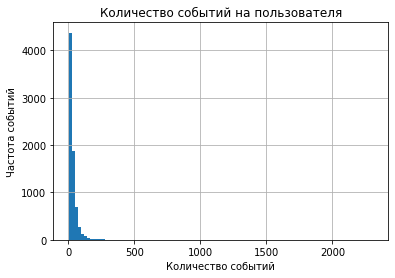

In [22]:
events.hist(bins=100)
plt.xlabel('Количество событий')
plt.ylabel('Частота событий')
plt.title("Количество событий на пользователя")
plt.show()

In [23]:
events.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000



Видно, что максимально значение очень большое, значит среднее значение брать не стоит, так как максимальное значение будет смещать среднее в большую сторону.


In [24]:
events['event_name'].median()

20.0


Так как распределение не является нормальным, обычно, смотрят на моду.


In [25]:
events['event_name'].mode()

0    5
dtype: int64


Чаще всего пользователи осуществляют 5 событий на сайте


<a id='actuality'></a>
**Актуальные данные**

In [26]:
'Минимальная дата : {}'.format(logs_data['date_time'].min())

'Минимальная дата : 2019-07-25 04:43:36'

In [27]:
'Максимальная дата : {}'.format(logs_data['date_time'].max())

'Максимальная дата : 2019-08-07 21:15:17'

In [28]:
logs_data['hour'] = logs_data['date_time'].dt.hour

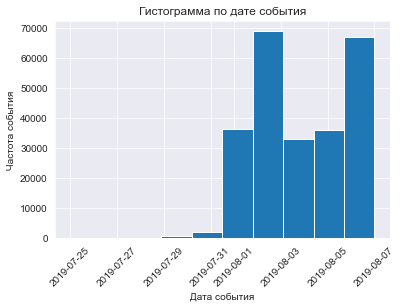

In [29]:
sns.set_style("dark")
logs_data['date'].hist()
plt.xticks(rotation=45)
plt.title('Гистограмма по дате события')
plt.xlabel('Дата события')
plt.ylabel('Частота события')
plt.show()

In [30]:
len(logs_data[logs_data['date'] =='2019-07-31'])

2030

In [31]:
len(logs_data[logs_data['date'] =='2019-08-01'])

36141

Видно, что до 31 июля включительно данных очень мало, скорее всего это связано с тем, что это данные из прошлого. А значит тест начался 1 августа, и данные до 1 августа можно удалить.

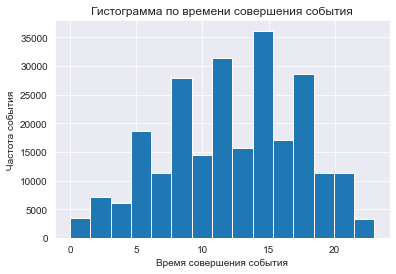

In [32]:
logs_data['hour'].hist(bins=15)
plt.title('Гистограмма по времени совершения события')
plt.xlabel('Время совершения события')
plt.ylabel('Частота события')
plt.show()


Видно, что в определенные часы у нас пик активности, а в определенные - спад.

---

In [33]:
logs_data_new = logs_data[(logs_data['date_time'] >= '2019-08-01')]

In [34]:
logs_data_new.shape

(240887, 8)

In [35]:
logs_data.shape[0] - logs_data_new.shape[0]

2826

In [36]:
(logs_data.shape[0] - logs_data_new.shape[0])/(logs_data.shape[0])* 100

1.159560630741897


Получилось, что отбросили 2826 событий, 1% данных. Это довольно мало, такое изменение не повлияет на результаты дальнейшего исследования

---

In [37]:
logs_data_new['user_id'].nunique()

7534

In [38]:
logs_data['user_id'].nunique() - logs_data_new['user_id'].nunique()

17

In [39]:
(logs_data['user_id'].nunique() - logs_data_new['user_id'].nunique())/logs_data['user_id'].nunique() * 100

0.22513574361011784


Из пользователей потеряли 17 человек, меньше  1%, что является незначительный потерей.

---

In [40]:
for number in(logs_data['exp_id'].unique()):
    display('Группа ' + number)
    display('Количество пользователей в группе {}'.\
            format(logs_data_new[logs_data_new['exp_id'] == number]['user_id'].nunique()))
    display('Количество событий в группе {}'.\
            format(logs_data_new[logs_data_new['exp_id'] == number]['event_name'].count()))


'Группа 246'

'Количество пользователей в группе 2484'

'Количество событий в группе 79302'

'Группа 248'

'Количество пользователей в группе 2537'

'Количество событий в группе 84563'

'Группа 247'

'Количество пользователей в группе 2513'

'Количество событий в группе 77022'


Видим, что в каждой группе имеются пользователи. Количество пользователей в группе примерно одинаковое, но в 248 группе пользователи были активнее, нежели чем в контрольных группах.


    
>В данном шаге:
>* Изучила количество событий, пользователей, среднее количество событий на пользователя
>* Изучила гистограммы по дате и времени, отбросила 1% событий и меньше 1% пользователей, так как эти данные пришли еще до начала тестов
>* Проверила количество пользователей и событий на каждую группу


<a id='funnel'></a>
### Шаг 4. Изучение воронки событий

<a id='eventsisin'></a>
Посмотрю, какие события встречаются в логах

In [41]:
events_is_in = logs_data_new.groupby('event_name', as_index=False).\
agg({'user_id':'count'})
events_is_in.rename(columns={'user_id':'frequency'}, inplace= True)
events_is_in = events_is_in.sort_values('frequency', ascending=False)
events_is_in

,event_name,frequency
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


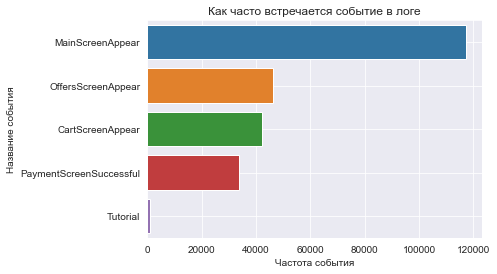

In [42]:
sns.set_style("dark")
sns.barplot(x='frequency', y='event_name', data=events_is_in)
plt.grid(True)
plt.title('Как часто встречается событие в логе')
plt.xlabel('Частота события')
plt.ylabel('Название события')
plt.show()


Чаще всего встречается событие MainScreenAppear, такие события как OffersScreenAppear,CartScreenAppear имеют почти одинаковые значения, а Tutorial встречается меньше всего.

<a id='usersperevents'></a>
Посчитаю, сколько пользователей совершали каждое из этих событий, а также долю пользователей, которые совершали союытие один раз.

In [43]:
users_per_events = logs_data_new.groupby('event_name', as_index=False).\
agg({'user_id':'nunique'})
users_per_events.rename(columns={'user_id':'number_of_users'}, inplace=True)

users_per_events['ratio'] = ((events_is_in['frequency'] - users_per_events['number_of_users'])/\
events_is_in['frequency']).map(lambda x: '{0:.2%}'.format(x))
users_per_events = users_per_events.sort_values('number_of_users', ascending=False)
users_per_events 

,event_name,number_of_users,ratio
1,MainScreenAppear,7419,93.68%
2,OffersScreenAppear,4593,90.09%
0,CartScreenAppear,3734,91.17%
3,PaymentScreenSuccessful,3539,89.57%
4,Tutorial,840,16.42%


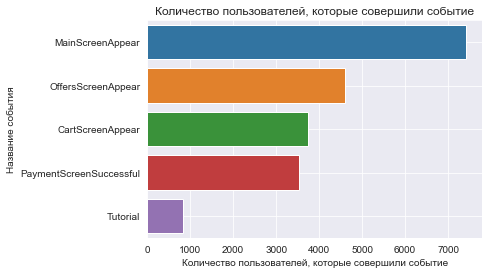

In [44]:
sns.set_style("dark")
sns.barplot(x='number_of_users', y='event_name', data=users_per_events)
plt.grid(True)
plt.title("Количество пользователей, которые совершили событие")
plt.xlabel('Количество пользователей, которые совершили событие')
plt.ylabel('Название события')
plt.show()

Только у события Tutorial маленький процент пользователей, которые совершали это осбытие более 1 раза. У остальных больше 88%.

<a id='eventsteps'></a>
Порядок событий следующий:
* Событие 1 - MainScreenAppear - пользователь заходит на  главную страницу;
* Событие 2 - OffersScreenAppear - пользователь выбирает продукты на странице продуктов;
* Событие 3 - CartScreenAppear - пользователь добавляет продукты в корзину;
* Событие 4 - PaymentScreenSuccessful - пользователь производит оплату;

---

Tutorial - пользователь заходит на страницу с обучением ( данное событие может появится на любой стадии, его я не буду включать в воронку 

In [45]:
users_per_events.drop(index=4, inplace=True)

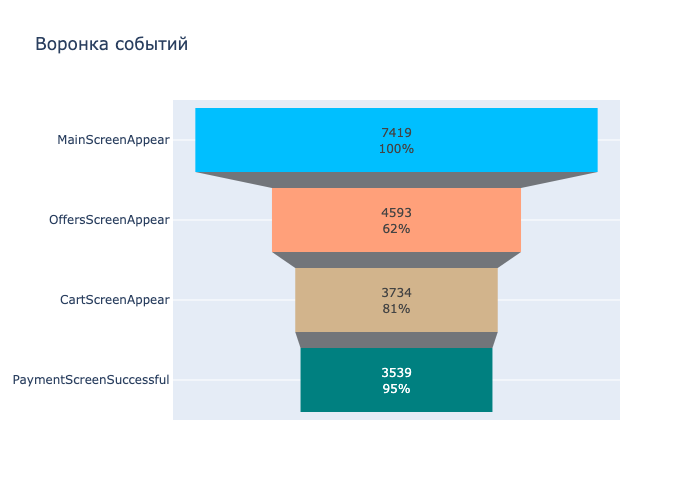

In [77]:
fig = go.Figure(go.Funnel(
x=users_per_events['number_of_users'],
y=users_per_events['event_name'],
textposition = "inside",
textinfo = "value+percent previous",
marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}),\
                layout_title_text="Воронка событий")
fig.update_traces(hovertemplate='of total: %{percentInitial}<br>'+\
                  'of previous: %{percentPrevious}')


fig.write_image("figname.png")
Image(filename='figname.png') 

<a id='funnelpercent'></a>
Больше всего пользователей (39%) теряется на первом шаге, что может говорить о том, что главная страница недостаточно презентабельна и наглядна, пользователю могло не понравится (шрифты, картинки, расположение на странице и тд.)

Также можно увидеть, что только 5 процентов людей уходят после добавления товара в корзину.

17% людей уходят после просмотра страницы с товарами, это может говорить о том, что они не нашли нужный им товар, или ценовая политика данного сервиса не устраивает пользователя.

До последнего события доходят 47,8% пользователей, очень неплохие показатели. Но  исследуемый промежуток у нас меньше 2 недель.

<a id='AABtests'></a>
### Шаг 5. Анализ результатов эксперемента

<a id='numberofuserstest'></a>
Количество пользователей в каждой эксперементальной группе

In [48]:
group246 = logs_data_new[logs_data_new['exp_id'] == '246']
group247 = logs_data_new[logs_data_new['exp_id'] == '247']
group248 = logs_data_new[logs_data_new['exp_id'] == '248']

In [49]:
'{} пользователей в эксперементальной группе 246'.format(group246['user_id'].nunique())

'2484 пользователей в эксперементальной группе 246'

In [50]:
'{} пользователей в эксперементальной группе 247'.format(group247['user_id'].nunique())

'2513 пользователей в эксперементальной группе 247'

In [51]:
'{} пользователей в эксперементальной группе 248'.format(group248['user_id'].nunique())

'2537 пользователей в эксперементальной группе 248'

<a id='statsdifference'></a>
Чтобы проверить статистическую значимость, 
сформирую нулевую гипотезу: Cтатистически значимых различий между долями в группах нет


Обратная гипотеза: между долями есть значимая разница


In [52]:
data = {'number_of_users':[group246['user_id'].nunique(),\
           group247['user_id'].nunique(),\
          group248['user_id'].nunique()]}
index=['246', '247', '248']
experiments = pd.DataFrame(data, index=index)
experiments

,number_of_users
246,2484
247,2513
248,2537


In [53]:
funnel = logs_data_new.pivot_table(index='event_name',
                                  columns='exp_id',
                                  values = 'user_id',
                                  aggfunc = 'nunique').sort_values(by='246', ascending=False)
funnel

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [54]:
def z_test(exp_1, exp_2):
    for event in logs_data_new['event_name'].unique():
        print("Событие: ", event)
        
        alpha =.05
    
        successes = [funnel.loc[event, exp_1], funnel.loc[event, exp_2]]
        trials = [experiments.loc[exp_1, 'number_of_users'], experiments.loc[exp_2, 'number_of_users']]
    
        p1 = successes[0] / trials[0]
        p2 = successes[1] / trials[1]
    
        p_comb = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
    
        z_value = difference/ mth.sqrt(p_comb*(1 - p_comb)*(1/trials[0]+1/trials[1]))
        distr = st.norm(0, 1)
    
        p_value = (1-distr.cdf(abs(z_value)))*2
        print('p-значения: ', p_value)
        if(p_value < alpha):
            print('Отвергаем нулевую гипотезу')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')


In [55]:
z_test('246', '247')


Событие:  Tutorial
p-значения:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  MainScreenAppear
p-значения:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  OffersScreenAppear
p-значения:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  CartScreenAppear
p-значения:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  PaymentScreenSuccessful
p-значения:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Видно, что нулевую гипотезу мы не смогли отвергнуть ни в одном событии между выборками 246 и 247. Получается, что результаты А/А-теста успешные,различий в показателях нет.

---

<a id='statABdiff'></a>
Теперь сравню результаты из каждой контрольной группы с экспериментальной группой.

In [56]:
z_test('246', '248')


Событие:  Tutorial
p-значения:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  MainScreenAppear
p-значения:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  OffersScreenAppear
p-значения:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  CartScreenAppear
p-значения:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  PaymentScreenSuccessful
p-значения:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [57]:
z_test('247', '248')


Событие:  Tutorial
p-значения:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  MainScreenAppear
p-значения:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  OffersScreenAppear
p-значения:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  CartScreenAppear
p-значения:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  PaymentScreenSuccessful
p-значения:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При сравнении с каждой контрольной группой, видно, что мы не смогли отвергнуть нулевую гипотезу, а значит разлий в показателях нет. Сравню с результатами, если объеденить контрольные группы.

---

In [58]:
funnel['comb'] = funnel['246'] + funnel['247']

In [59]:
funnel

exp_id,246,247,248,comb
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [60]:
experiments

,number_of_users
246,2484
247,2513
248,2537


In [61]:
experiments.loc['comb', 'number_of_users'] = experiments.loc['246', 'number_of_users'] +\
experiments.loc['247', 'number_of_users']

In [62]:
experiments

,number_of_users
246,2484.0
247,2513.0
248,2537.0
comb,4997.0


In [63]:
z_test('comb', '248')


Событие:  Tutorial
p-значения:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  MainScreenAppear
p-значения:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  OffersScreenAppear
p-значения:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  CartScreenAppear
p-значения:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  PaymentScreenSuccessful
p-значения:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Можно сделать вывод по анализу, что понять, влияют ли изменения с шрифтами или нет, - нельзя.

При проверке статистических гипотез выше я выбрала уровень значимости = 0.05

Видно, что значение p-value выше 0.1 почти во всех ситуациях. Если мы возьмем такое значение, то в одном из событий между группой 246 и 248 появится статистическая значимость. Но, при таком уровне значимости, каждый десятый раз можно получать ложный результат. В моем случае, именно эта проверка могла оказаться этим 10-ым случаем. Чем выше уровень значимости я возьму, тем больше вероятность возникновения ошибки первого рода. Выше значения 0.1 я не вижу смысла поднимать, так как будет высокая вероятность ошибки первого рода, а ниже 0.05 опускать тоже нет смысла, так как результат будет такой же, какой я получила сейчас. Приняла решение оставить данный уровень статистической значимости.

In [64]:
users_per_events_246 = group246.groupby('event_name', as_index=False).\
agg({'user_id':'nunique'})
users_per_events_246.rename(columns={'user_id':'number_of_users'}, inplace=True)
users_per_events_246.drop(index=4, inplace=True)
users_per_events_246 = users_per_events_246.sort_values('number_of_users', ascending=False)

In [65]:
users_per_events_247 = group247.groupby('event_name', as_index=False).\
agg({'user_id':'nunique'})
users_per_events_247.rename(columns={'user_id':'number_of_users'}, inplace=True)
users_per_events_247.drop(index=4, inplace=True)
users_per_events_247 = users_per_events_247.sort_values('number_of_users', ascending=False)

In [66]:
users_per_events_248 = group248.groupby('event_name', as_index=False).\
agg({'user_id':'nunique'})
users_per_events_248.rename(columns={'user_id':'number_of_users'}, inplace=True)
users_per_events_248.drop(index=4, inplace=True)
users_per_events_248 = users_per_events_248.sort_values('number_of_users', ascending=False)

**Воронка для группы 246**

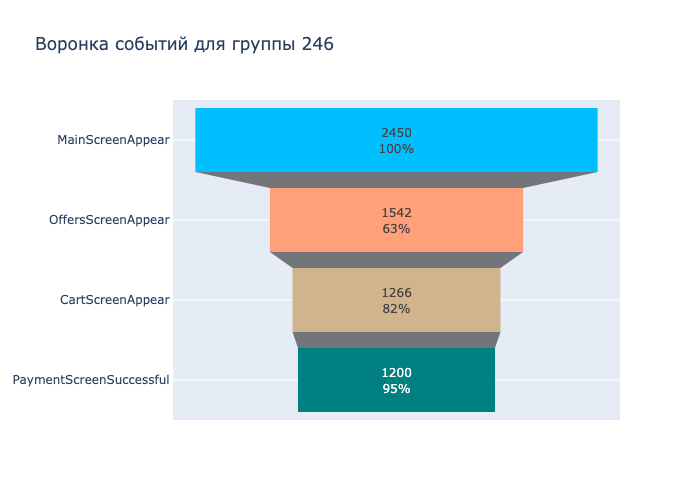

In [78]:
fig = go.Figure(go.Funnel(
x=users_per_events_246['number_of_users'],
y=users_per_events_246['event_name'],
textposition = "inside",
textinfo = "value+percent previous",
marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}),\
               layout_title_text="Воронка событий для группы 246")
fig.update_traces(hovertemplate='of total: %{percentInitial}<br>'+\
                  'of previous: %{percentPrevious}')

fig.write_image("figname1.png")
Image(filename='figname1.png') 

**Воронка для группы 247**

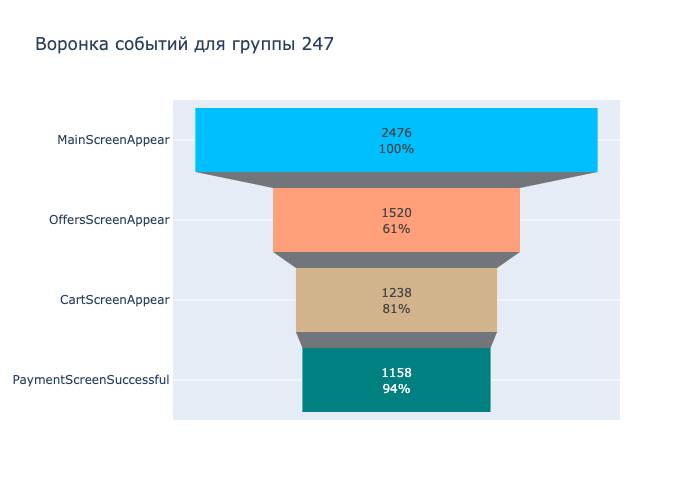

In [79]:
fig = go.Figure(go.Funnel(
x=users_per_events_247['number_of_users'],
y=users_per_events_247['event_name'],
textposition = "inside",
textinfo = "value+percent previous",
marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}),\
               layout_title_text="Воронка событий для группы 247")
fig.update_traces(hovertemplate='of total: %{percentInitial}<br>'+\
                  'of previous: %{percentPrevious}')
fig.write_image("figname247.png")
Image(filename='figname247.png') 

**Воронка для группы 248**

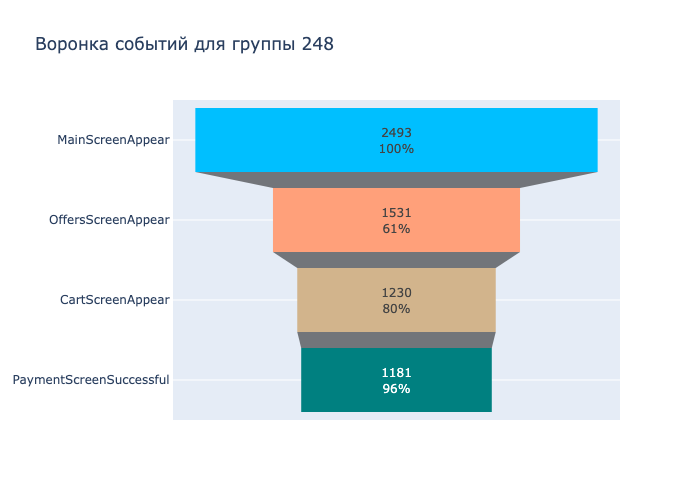

In [80]:
fig = go.Figure(go.Funnel(
x=users_per_events_248['number_of_users'],
y=users_per_events_248['event_name'],
textposition = "inside",
textinfo = "value+percent previous",
marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}),\
               layout_title_text="Воронка событий для группы 248")
fig.update_traces(hovertemplate='of total: %{percentInitial}<br>'+\
                  'of previous: %{percentPrevious}')
fig.write_image("figname248.png")
Image(filename='figname248.png') 

В последней группе до оплаты дошли 47,4% пользователей от первоначального числа, в 246 и 247 группе эта цифра была меньше(49% и 46,8% соответственно). Так как наши тесты получились статистически незначимыми, то утверждать, что данный процесс произошел из-за того, что был изменен шрифт - нельзя.

При переходе с первого на второе событие было отсеяно (37,1%,38,6%,38,6%) по каждой из групп(246,247,248) соответственно. Но в первой и второй группе был один шрифт. Но, можно заметить, что в экспериментальной группе меньше людей добавили продукт в корзину и продолжили покупки на 1% процент.

<a id='conclusion'></a>
### Шаг 6. Вывод

В ходе работы была проведена предобработка данных, исследованы пропуски и дубликаты.

Изменены типы на подходящие для удобной работы и исследования.

Также были добавленны новые столбцы в датафрейм, для получения более детальной информации по дате и времени.

Было изучено количество пользователей и событий в логе, количество пользователей в каждом событии.

Чаще всего на одного пользователя приходится 5 событий.

Также срезала данные до  2019-08-01 , так как их значение очень мало, вполне возможно это данные, пришедшие из дней, до начала теста

Исследовав количество пользователей на каждом событии и отсортировав из по количеству, было решено, что последовательность событий будет такая:
* Событие 1 - MainScreenAppear - пользователь заходит на главную страницу;
* Событие 2 - OffersScreenAppear - пользователь выбирает продукты на странице продуктов;
* Событие 3 - CartScreenAppear - пользователь добавляет продукты в корзину;
* Событие 4 - PaymentScreenSuccessful - пользователь производит оплату;

Изучив воронку, выяснила, что больше всего пользователей (39%) теряется на первом шаге, что может говорить о том, что главная страница недостаточно презентабельна и наглядна, пользователю могло не понравится (шрифты, картинки, расположение на странице и тд.)

18% людей уходят после просмотра страницы с товарами, это может говорить о том, что они не нашли нужный им товар, или ценовая политика данного сервиса не устраивает пользователя. Но, в общем, 47% пользователей доходят до покупки товара, что является хорошим показателем.

После анализа результатов эксперимента, сделала выводы:
* Различий между контрольными группами нет, значит тесты прошли успешно
* Статистической значимости между контрольными и экспериментальной группы нет,что может говорить о том, что сделать вывод влияет ли шрифт на поведение пользователя в сервисе или нет, - сложно.
* После построения воронок для каждой группы, было решено, что тест стоит прекратить, так как вероятность влияния шрифта на поведение пользователя очень мала.